In [1]:
import pandas as pd
import geopandas as gpd
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import math

In [2]:
op_ar = [1, 1.01, 1.025]
if_ar = [0, 0.25, 1]

In [3]:
nl_nuts = gpd.read_file('nl_nuts.shp')

In [ ]:
# Path to results


path = os.path.join(os.path.dirname(os.getcwd()), 'src\rfesults')

In [5]:
absbins = [-1000, -16, -12, -8, -4, 0, 4 , 8, 12, 16, 1000]

In [6]:
def output_calculator(op_factor, imp_flex, dis, nl_nuts):

    Xdis = pd.read_excel(os.path.join(path, f'Xdis3_{op_factor}_{imp_flex}_{dis}_mosek.xlsx'), index_col = [0], header = [1])
    Xdis = Xdis.drop("Index2", axis = 'index')
    
    Xbase = pd.read_excel(os.path.join(path, f'Xbase_{op_factor}_{imp_flex}_{dis}_mosek.xlsx'), index_col = [0], header = [1])
    Xbase = Xbase.drop("Index2", axis = 'index')
    
    X_diff = Xbase - Xdis
    
    for m in range(len(nl_nuts)):
        nuts_id = nl_nuts.loc[m,'NUTS_ID']
        output_change =  X_diff.loc[:,nuts_id].sum()
        nl_nuts.loc[m,'output_change'] = output_change / 365

    return nl_nuts

In [7]:
def assign_bands(loss_ss_ci, absbins):
    

    abslabels = np.arange(1,11,1)
    
    color_dict = {
    1: '#03045e' , 
    2: '#0077b6',
    3: '#00b4d8',
    4: '#90e0ef',
    5: '#caf0f8', 
    6: '#fed0bb',
    7: '#fcb9b2',
    8: '#b23a48',
    9: '#8c2f39',
    10: '#461220'
    }
    
    # Adding band columns
    loss_ss_ci['band_absolute'] = pd.cut(loss_ss_ci['output_change'], bins=absbins, labels=abslabels, right=False)

    # Add the color code column
    loss_ss_ci['color_code_abs'] = loss_ss_ci['band_absolute'].map(color_dict)
    return loss_ss_ci

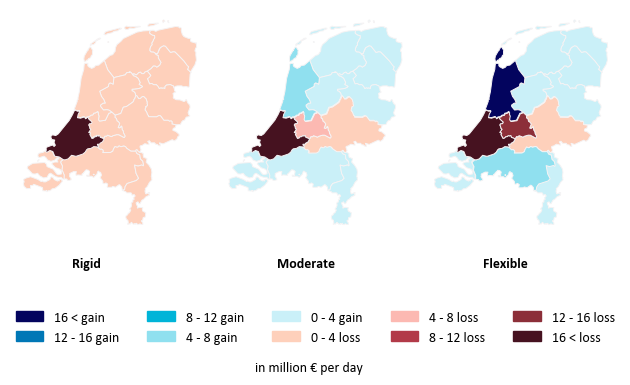

In [10]:
fig = plt.figure(figsize=(7, 4.5))
gs = fig.add_gridspec(2, 3, height_ratios=[1, 0.2])  


axes = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1]), fig.add_subplot(gs[0, 2])]
ax1, ax2, ax3 = axes
label_posx = 0.3
label_posy = -0.1


# Plot rigid dataset
rigid = output_calculator(1, 0, 0.1, nl_nuts)
rigid = assign_bands(rigid, absbins)

for color in rigid['color_code_abs'].unique():
    subset1 = rigid[rigid['color_code_abs'] == color]
    subset1.plot(ax=ax1, color=color, edgecolor='#f5f3f4', linewidth=0.7)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_axis_off()
ax1.text(label_posx, label_posy , 'Rigid', transform=ax1.transAxes, fontsize=10, fontweight='bold', fontname = 'Calibri', va='top', ha='left')

# Plot moderate dataset
moderate = output_calculator(1.01, 0.25, 0.1, nl_nuts)
moderate = assign_bands(moderate, absbins)

for color in moderate['color_code_abs'].unique():
    subset2 = moderate[moderate['color_code_abs'] == color]
    subset2.plot(ax=ax2, color=color, edgecolor='#f5f3f4', linewidth=0.7)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_axis_off()
ax2.text(label_posx, label_posy , 'Moderate', transform=ax2.transAxes, fontsize=10, fontweight='bold', fontname = 'Calibri', va='top', ha='left')

# Plot flexible dataset

flexible = output_calculator(1.025, 1, 0.1, nl_nuts)
flexible = assign_bands(flexible, absbins)

for color in flexible['color_code_abs'].unique():
    subset3 = flexible[flexible['color_code_abs'] == color]
    subset3.plot(ax=ax3, color=color, edgecolor='#f5f3f4', linewidth=0.7)
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_axis_off()
ax3.text(label_posx, label_posy , 'Flexible', transform=ax3.transAxes, fontsize=10, fontweight='bold', fontname = 'Calibri', va='top', ha='left')

fig_legend = fig.add_subplot(gs[1, :])

color_labels = {
f'{ -1*round(absbins[1])} < gain ': '#03045e' , 
f'{-1*round(absbins[2])} - {-1*round(absbins[1])} gain': '#0077b6',
f'{-1*round(absbins[3])} - {-1*round(absbins[2])} gain': '#00b4d8',
f'{-1*round(absbins[4])} - {-1*round(absbins[3])} gain': '#90e0ef',
f'{round(absbins[5])} - {-1*round(absbins[4])} gain': '#caf0f8', 
f'{round(absbins[5])} - {round(absbins[6])} loss': '#fed0bb',
f'{round(absbins[6])} - {round(absbins[7])} loss': '#fcb9b2',
f'{round(absbins[7])} - {round(absbins[8])} loss': '#b23a48',
f'{round(absbins[8])} - {round(absbins[9])} loss': '#8c2f39',
f'{round(absbins[9])} < loss': '#461220'
}


# Create legend handles
legend_handles = [Patch(color=color, label=label) for label, color in color_labels.items()]

# Add the legend to the axis
fig_legend.legend(handles=legend_handles, loc='upper center', ncol= 5,  prop={'size': 10, 'family': 'Calibri'}, frameon=False)

# Remove axis
fig_legend.axis('off')
fig_legend.text(0.4, 0.05 , 'in million € per day', transform = fig_legend.transAxes, fontsize=10, fontname = 'Calibri', va='top', ha='left')
plt.tight_layout()
plt.savefig(f'spatial_plot.png', dpi=300, bbox_inches='tight')
plt.show()